In [77]:
%matplotlib inline

In [78]:
import zipfile
import os

In [79]:
path = "../data"

In [80]:
os.listdir(path)

['.DS_Store',
 'dogs_vs_cats.h5',
 'test',
 'test.zip',
 'train',
 'train.zip',
 'val']

In [150]:
zip_train = "/train.zip"
zip_test = "/test.zip"
zip_train = zipfile.ZipFile(path + zip_train, 'r')
zip_test = zipfile.ZipFile(path + zip_test, 'r')
zip_train.extractall(path)
zip_test.extractall(path + '/test')

In [82]:
os.listdir(path)

['.DS_Store',
 'dogs_vs_cats.h5',
 'test',
 'test.zip',
 'train',
 'train.zip',
 'val']

In [83]:
train_dir = "/train"
test_dir = "/test"
class_cat = "/cat"
class_dog = "/dog"

In [84]:
import glob
import shutil

In [27]:
sourcepath = path+train_dir
train_cat_dest = path+train_dir+class_cat+"/"
train_dog_dest = path+train_dir+class_dog+"/"

if not os.path.exists(cat_dest):
    os.makedirs(cat_dest)
    
if not os.path.exists(dog_dest):
    os.makedirs(dog_dest)

files = os.listdir(sourcepath)

for file in files:
    if file.startswith('cat') and file.endswith('.jpg'):
        shutil.move(os.path.join(sourcepath,file), os.path.join(cat_dest,file))
        
for file in files:
    if file.startswith('dog') and file.endswith('.jpg'):
        shutil.move(os.path.join(sourcepath,file), os.path.join(dog_dest,file))

In [32]:
val_dir = "/val"
val_cat_dest = path+val_dir+class_cat+"/"
val_dog_dest = path+val_dir+class_dog+"/"

if not os.path.exists(cat_dest):
    os.makedirs(cat_dest)
    
if not os.path.exists(dog_dest):
    os.makedirs(dog_dest)
    
for n in range(0,2500):
    cat_filename = "cat."+str(n)+".jpg"
    shutil.move(train_cat_dest+cat_filename, val_cat_dest)
    dog_filename = "dog."+str(n)+".jpg"
    shutil.move(train_dog_dest+dog_filename, val_dog_dest)

In [85]:
from matplotlib import pyplot as plt
from keras.preprocessing.image import ImageDataGenerator as IDG
import numpy as np
from utils import plot_batch

In [86]:
idg = IDG()

In [87]:
classes = ['cat','dog']
class_mode = 'binary'
batch_size = 16
path_train = path + "/train"
path_val = path + "/val"
path_test = path + "/train"
train_images = idg.flow_from_directory(path_train, batch_size=batch_size, shuffle=True, class_mode=class_mode, classes=classes)
val_images = idg.flow_from_directory(path_val, batch_size=batch_size, shuffle=True, class_mode=class_mode, classes=classes)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [88]:
num_of_samples = 20000.

In [89]:
train_batch, train_labels = train_images.next()
val_batch, val_labels = val_images.next()

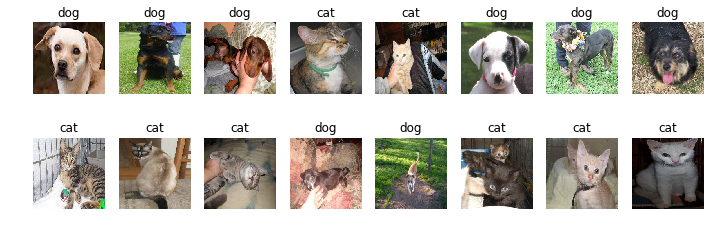

In [90]:
plot_batch(val_batch,val_labels,classes)

In [91]:
batch.shape

(16, 256, 256, 3)

In [92]:
from keras.applications.vgg16 import VGG16

In [93]:
image_shape = batch.shape[1:]
vgg16_base = VGG16(include_top=False, weights='imagenet', input_tensor=None, input_shape=image_shape, pooling=None)

In [94]:
vgg16_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
__________

In [95]:
from keras.layers import Flatten, Dense
from keras.models import Model

vgg16_top = vgg16_base.output
vgg16_top = Flatten()(vgg16_top)
# let's add a fully-connected layer
vgg16_top = Dense(1024, activation='relu')(vgg16_top)
# and a logistic layer -- let's say we have 2 classes
vgg16_top = Dense(1, activation='sigmoid')(vgg16_top)

# this is the model we will train
model = Model(inputs=vgg16_base.input, outputs=vgg16_top)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional layers
for layer in vgg16_base.layers:
    layer.trainable = False

In [96]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
__________

In [97]:
from keras import optimizers
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

In [59]:
num_batches = 100./batch_size
epochs = 1
steps_per_epoch = batch_size
# fine-tune the model
model.fit_generator(train_images, steps_per_epoch=num_batches, epochs=epochs, 
                    validation_data=val_images, validation_steps=10) 

Epoch 1/1
7/6 [=================================] - 306s - loss: 1.9121 - acc: 0.8125 - val_loss: 1.2208 - val_acc: 0.8812


In [98]:
weights_file = path + '/dogs_vs_cats.h5'

In [ ]:
model.save(weights_file)

In [100]:
model.load_weights(weights_file)

In [145]:
test_images = idg.flow_from_directory(path + test_dir + "/", batch_size=1, class_mode=None, shuffle=False)
files = test_images.filenames

Found 12513 images belonging to 1 classes.


In [148]:
for n in range(0, 10):
    batch = test_images.next()
    print(model.predict(batch), files[n])

[[ 1.]] test/1.jpg
[[ 0.67614442]] test/10.jpg
[[ 0.0009127]] test/100.jpg
[[ 1.]] test/1000.jpg
[[ 1.]] test/10000.jpg
[[ 0.]] test/10001.jpg
[[  4.70003404e-14]] test/10002.jpg
[[  4.70421424e-10]] test/10003.jpg
[[ 0.]] test/10004.jpg
[[  4.40748883e-26]] test/10005.jpg
